In [128]:
import os

folder_prod = os.listdir("../Con produccion")
folder_sin_prod = os.listdir("../Sin produccion")

folder_sin_prod

['2019-11-04 12-48 enfriamiento1.csv', '1 -  enfriamiento.csv']

In [130]:
#Files con Produccion
df_list = []
df_names = []
for file in folder_prod:

    bd=sqlContext.read.format("com.databricks.spark.csv").option("header","false").load(
    "file:/home/luca/Desktop/Tecnocom/csvs/Con produccion/"+str(file))
    
    df_prod = bd.toPandas().transpose().reset_index()
    df_prod = df_prod.drop(columns="index")
    df_names.append(file)
    df_list.append(df_prod)
    



In [131]:
#Files sin Produccion
df_list_np = []
df_names_np = []
for file1 in folder_sin_prod:

    bd1=sqlContext.read.format("com.databricks.spark.csv").option("header","false").load(
    "file:/home/luca/Desktop/Tecnocom/csvs/Sin produccion/"+str(file1))
    
    df_np = bd1.toPandas().transpose().reset_index()
    df_np = df_np.drop(columns="index")
    df_names_np.append(file1)
    df_list_np.append(df_np)
    

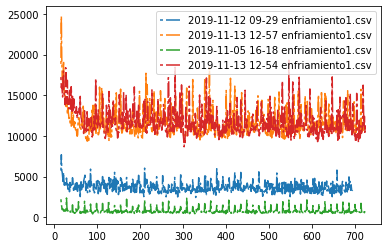

In [132]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
i = 0

for df in df_list:

    x = df.index.values[15:].astype(int)
    y = df[0].values[15:].astype(float)

    line1 = ax.plot(x , y, dashes=[2, 2, 10, 2], label=df_names[i])
    #line1.set_dashes([2, 2, 10, 2])
    i += 1
    
ax.legend()
plt.show()
    

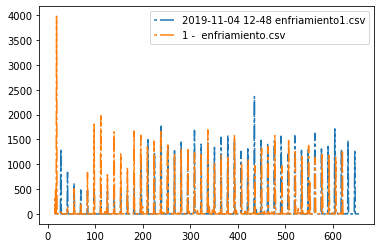

In [133]:
fig, ax = plt.subplots()
i = 0
for df in df_list_np:

    x = df.index.values[15:].astype(int)
    y = df[0].values[15:].astype(float)

    line1 = ax.plot(x , y, dashes=[2, 2, 10, 2], label=df_names_np[i])
    #line1.set_dashes([2, 2, 10, 2])
    i += 1
    
ax.legend()
plt.show()

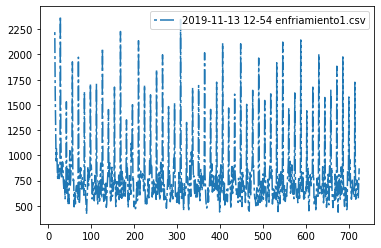

In [140]:
fig, ax = plt.subplots()
x = df_list[2].index.values[15:].astype(int)
y = df_list[2].values[15:].astype(float)

line1 = ax.plot(x , y, dashes=[2, 2, 10, 2], label=df_names[i])
#line1.set_dashes([2, 2, 10, 2])
i += 1

ax.legend()
plt.show()

420.0

In [147]:
#df_list_np[0].values[30:].astype(int).min()
df_list_np[1].values[45:60].astype(int).min()


0